## DEEP LEARNING : FRUITS_RECOGNITION WITH TRANSFER LEARNING

The goal of the project if to classify fruit images over 81 different classes of fruits. We have several images for train and test sets. For a higher performance of this project, we will use GPU processing instead of CPU. So, we have to check along the project that we have GPU in our system ready to use.

Also we will use Transfer Learning to reach our goal. The purpose is to compare the results obtained with this method, with the ones obtained with a custom neural network. Transfer Learning helps to develop a trained network quickly as we can use an already trained network and its calculated weights with our actual train set. The advantage of this method is that the network is already trained, so it is a quick solution or first step. But we will remove the fully connected layers and replace them by the fully connected layers in our actual problem.

In [6]:
#For printing out the info of the possible devices

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

tf.version.VERSION
print("Num GPUs Available: ", tf.config.list_physical_devices())


'2.1.0'

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#Importing some libraries

import numpy as np
import pandas as pd
import scipy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #Para ploteados más nítidos

#To allow several outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

### LOAD THE DATA IN BATCHES (BIG DATASETS)

In [10]:
#We will use batches to load the data and also Keras module "ImageDataGenerator":

images_dir_train = r'D:\fruits-360\Training'
images_dir_test = r'D:\fruits-360\Test'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
epochs=20
train_datagen = ImageDataGenerator(rescale=1. / 255) 
                                    #zoom_range=0.2,
                                    #rotation_range = 5,
                                    #horizontal_flip=True)
test_datagen=   ImageDataGenerator(rescale=1. / 255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(  
                  images_dir_train,
                  target_size=(100, 100),
                  batch_size=batch_size,
                  class_mode='categorical')

val_generator =  test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='training')

test_generator = test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='validation',
                 shuffle=False)       #Not shuffling test set makes easier to test the predictions as the filenames are saved
                                      #in alphabetical order


Found 41322 images belonging to 81 classes.
Found 6942 images belonging to 81 classes.
Found 6935 images belonging to 81 classes.


### DEFINE MODELS, TRAIN AND SAVE THE RESULTS

Perhaps three of the most popular models for transfer learning are as follows (ordered by top accuracy in ImageNet validation set):

    -Xception
    -VGG (e.g. VGG16 or VGG19): expects color input images to be rescaled to the size of 224×224 squares
    -Residual Network (e.g. ResNet50):expects color images to have the square shape 224×224
    -GoogLeNet (e.g. InceptionV3):The model expects color images to have the square shape 299×299


These models are all widely used for transfer learning because of their performance, but also because they introduced specific architectural innovations, namely consistent and repeating structures (VGG), inception modules (GoogLeNet), and residual modules (ResNet).

To train only the fully connected layers of the algorithm, we should delete these layers from the default model, via the option 'include_top=False'; then to connect the output of the algorithm without these last layers (activation functions) with the fully connected layers that we have to define and add to the model, we need to flat the output (activation functions) via two options: one is using pooling option argument when defining the model, and the other one is adding a Flatten layer before adding the fully connected layers. We will use the flatten option as it seems that provides a light better accuracy in training and validation results.

In [4]:
#Loading libraries to import pre-trained models
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

As we have mentioned above, we don´t want to train all the model network, we want to use the pre-trained weights for each model, and will only train the last layers (fully connected ones). So we will remove these layers with the "include_top=False" option in the parameters of each model. 

Also we have to define the new image size of our dataset with input_tensor parameter. As we are not going to use fully connected layers from the trained model, the output of the pre-trained model will be the activation functions of the last layer in CNN network, so we have to two options for joining this output data with our custom fully connected layers:
    -Adding a 'max' or 'avg' pooling layer with the pooling argument of each model.
    -Adding a Flatten layer.

After trying both methods, we could see a better performance with the Flatten layer, so this will be the chosen option:

In [11]:
#Defining the models

from tensorflow.keras.layers import Input
new_input=Input(shape=(100,100,3))

model_vgg16=VGG16(weights='imagenet',include_top=False, input_tensor=new_input)
model_vgg19=VGG19(weights='imagenet',include_top=False, input_tensor=new_input)
model_resnet50=ResNet50(weights='imagenet',include_top=False, input_tensor=new_input)
model_xception=Xception(weights='imagenet',include_top=False, input_tensor=new_input)
model_inception3=InceptionV3(weights='imagenet',include_top=False, input_tensor=new_input)

Now we have to deactivate the fully connected layers in each one of the previous pre-trained models:

In [5]:
#Custom function to deactivate the fully connected layers in a model:

def deactivate_fully(model):
    for layer in model.layers:
        layer.trainable=False
    print('Deactivated layers in model: ' + model.name )

deactivate_fully(model_vgg16)
deactivate_fully(model_vgg19)
deactivate_fully(model_resnet50)
deactivate_fully(model_xception)
deactivate_fully(model_inception3)


Deactivated layers in model: vgg16
Deactivated layers in model: vgg19
Deactivated layers in model: resnet50
Deactivated layers in model: xception
Deactivated layers in model: inception_v3


After removing the default fully connected layers in pre-trained models, we have to add the new fully connected ones:

In [32]:
#Adding the fully connected layers and creating and compiling model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

def creating_model(model):
    x=model.layers[-1].output
    x=Flatten()(x)
    x=Dense(1024, activation='relu')(x)
    x=Dropout(0.4)(x)
    output=Dense(81, activation='softmax', name='predictions')(x)

    model=Model(inputs=model.inputs, outputs=output, name=model.name)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mod_vgg16=creating_model(model_vgg16)
mod_vgg19=creating_model(model_vgg19)
mod_resnet50=creating_model(model_resnet50)
mod_xception=creating_model(model_xception)
mod_inception3=creating_model(model_inception3)

In [39]:
#Defining checkpoints to save work as training

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau


def callback_model(model):
    filepath_abs=r'D:\fruits-360\trained_weights'
    filepath_rel='\epochs_'+model.name+'_flatten'+r'\training_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5'
    filepath=filepath_abs+filepath_rel

    lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
    checkpoint=ModelCheckpoint(filepath=filepath,
                           save_weights_only=False,
                           monitor='val_accuracy',
                           mode='max',
                           save_freq='epoch',
                           verbose=1,
                           save_best_only=False)
    return [lr_reduce, checkpoint]

In [17]:
#Custom function to train a model

def train_model(model):
    history=model.fit(train_generator,
                  steps_per_epoch=train_generator.samples//batch_size, 
                  validation_data=val_generator, 
                  validation_steps=val_generator.samples//batch_size, 
                  epochs=epochs,
                  verbose=1,
                  shuffle=True,
                  callbacks=callback_model(model))
    return history

In [ ]:
#Training the pre-trained models

history_vgg16=train_model(mod_vgg16)
history_vgg19=train_model(mod_vgg19)
history_resnet50=train_model(mod_resnet50)
history_inception=train_model(mod_inception3)
history_xception=train_model(mod_xception)

In [4]:
#changing the default dir for saving the history
import os
os.getcwd()

os.chdir(r'D:\fruits-360\trained_weights')
os.getcwd()

'D:\\fruits-360\\trained_weights'

In [37]:
#Saving history of training

import pandas as pd
hist_df = pd.DataFrame(history.history) 

#save hist_df to csv: 
list_=['history_vgg16.csv', 'history_vgg19.csv', 'history_resnet50.csv', 'history_inception3.csv', 'history_xception.csv']
for i in list_:
    hist_csv_file = i
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [74]:
#Importing saved files

import h5py
def save_model(model):
    model_weights=r'D:\fruits-360\trained_weights\fruits_25epoch_'+model.name+'_flatten.h5'
    model.save(model_weights)

save_model(mod_vgg16)
save_model(mod_vgg19)
save_model(mod_resnet50)
save_model(mod_inception3)
save_model(mod_xception)

### COMPARING DIFFERENT MODELS PERFORMANCE

In [16]:
#Scores with flatten layer

def scores_model(model):
    
    load_path=r'D:\fruits-360\trained_weights\fruits_25epoch_'+model.name+'_flatten.h5'
    model.load_weights(load_path)
    
    scores_train=model.evaluate(train_generator, verbose=1)
    scores_validation=model.evaluate(val_generator, verbose=1)
    
    #print((model.name).upper())
    #print('Train Accuracy: %.2f%%' % (scores_train[1]*100))
    #print('Validation Accuracy: %.2f%%' % (scores_validation[1]*100)+'\n')
    return scores_train, scores_validation
    

In [71]:
#Custom function to compare several models performance

def compare_model(models):
    new_index=[]
    init_index=[]
    accuracy=pd.DataFrame(columns=['Train_accuracy','Val_accuracy'])
    losses=pd.DataFrame(columns=['Train_loss','Val_loss'])
    for idx,model in enumerate(models):
        scores_train, scores_val=scores_model(model)
        accuracy.at[idx,:]=scores_train[1],scores_val[1]
        losses.at[idx,:]=scores_train[0],scores_val[0]
        new_index.append(model.name)
    
    for i in range(len(models)):
        init_index.append(i)
    dict_index=dict(zip(init_index,new_index))
    accuracy=accuracy.rename(index=dict_index)
    losses=losses.rename(index=dict_index)
    
    return accuracy,losses


In [72]:
#Performing the comparison

accuracy, losses=compare_model([mod_vgg16,mod_vgg19,mod_resnet50,mod_inception3,mod_xception])

217/217 [==============================] - 15s 67ms/step - loss: 0.3595 - accuracy: 0.9548
VGG16
Train Accuracy: 99.47%
Validation Accuracy: 95.48%

217/217 [==============================] - 18s 82ms/step - loss: 0.3943 - accuracy: 0.9460
VGG19
Train Accuracy: 99.40%
Validation Accuracy: 94.60%

217/217 [==============================] - 15s 71ms/step - loss: 2.1856 - accuracy: 0.4022
RESNET50
Train Accuracy: 48.99%
Validation Accuracy: 40.22%

217/217 [==============================] - 8s 38ms/step - loss: 1.9971 - accuracy: 0.8879
INCEPTION_V3
Train Accuracy: 99.38%
Validation Accuracy: 88.79%

217/217 [==============================] - 13s 60ms/step - loss: 1.4837 - accuracy: 0.92880s - loss: 1.483
XCEPTION
Train Accuracy: 99.44%
Validation Accuracy: 92.88%



Some conclusions: resnet50 shows underfitting (perhaps we need a longer training with this network as it is extremely big), The rest of CNN are similar in performance, we can observe a little of overfitting in all of them, but vgg16 network performs better, so we will choose this model for performing fine tuning and compare with this option.

In [91]:
#Result of comparison
accuracy
losses

,Train_accuracy,Val_accuracy
vgg16,0.994749,0.954768
vgg19,0.993998,0.945981
resnet50,0.489909,0.40219
inception_v3,0.993805,0.887929
xception,0.99441,0.928839


,Train_loss,Val_loss
vgg16,0.00831205,0.359547
vgg19,0.0133734,0.394341
resnet50,1.92123,2.18565
inception_v3,0.0144115,1.99707
xception,0.0128083,1.4837


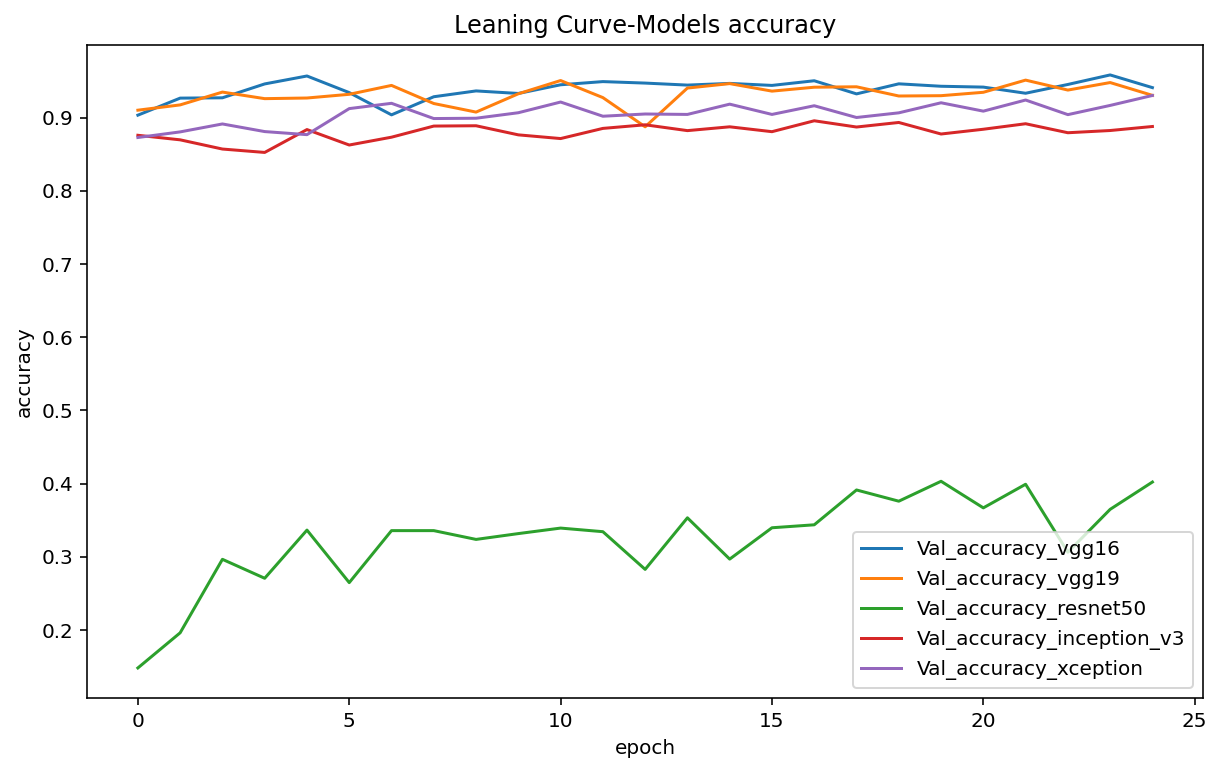

In [17]:
def Learning_curve (model):
    
    learning=pd.read_csv(r'D:\fruits-360\trained_weights'+'\history_'+model.name+'.csv', header=0, index_col=0)
    
    #plt.plot(learning['accuracy'], label='Train accuracy_'+model.name)
    
    plt.plot(learning['val_accuracy'], label='Val_accuracy_'+model.name)
    plt.title('Leaning Curve-Models accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')

plt.figure(figsize=(10,6))
Learning_curve(mod_vgg16)
Learning_curve(mod_vgg19)
Learning_curve(mod_resnet50)
Learning_curve(mod_inception3)
Learning_curve(mod_xception);

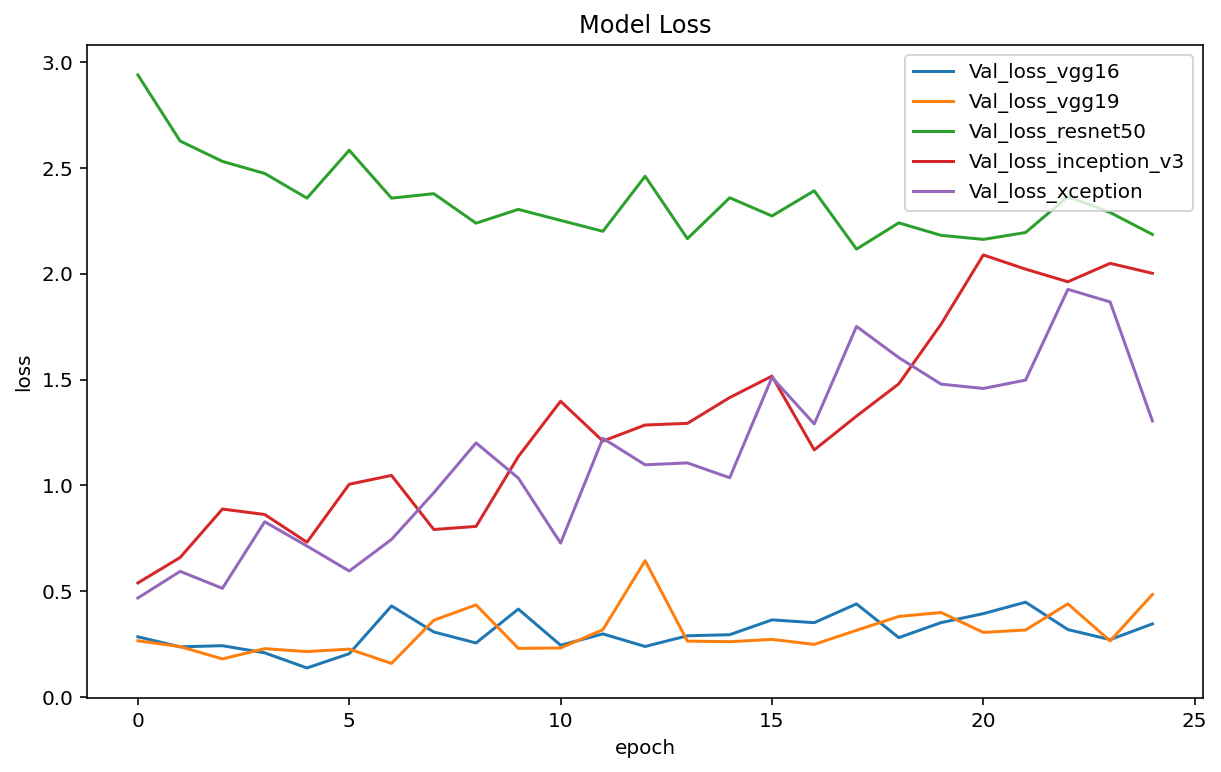

In [18]:
def Loss_curve (model):
    
    learning=pd.read_csv(r'D:\fruits-360\trained_weights'+'\history_'+model.name+'.csv', header=0, index_col=0)
    
    #plt.plot(learning['loss'], label='Train loss_'+model.name)
    plt.plot(learning['val_loss'], label='Val_loss_'+model.name)
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

plt.figure(figsize=(10,6))
Loss_curve(mod_vgg16)
Loss_curve(mod_vgg19)
Loss_curve(mod_resnet50)
Loss_curve(mod_inception3)
Loss_curve(mod_xception);

### CHOOSEN MODEL: VGG16 - SUMMARY


In [104]:
mod_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

### VGG16 FINE TUNING

We have already a model with overfitting, so we know in advance that performing a Fine Tuning is not going to help with this, because we are going to train last layers of pre-trained model, so we are fitting even more the model to the data. But, it is a good idea for demonstrative purposes, and to compare results with the obtained previously.

In [44]:
#Deactivate the fully connected layers and in this case also the last layers, called 'Block 5' in the model:

model_vgg16=VGG16(weights='imagenet',include_top=False, input_tensor=new_input)
mod_vgg16=creating_model(model_vgg16)
for layer in mod_vgg16.layers:
    if layer.name=='block5_conv1':
        break
    layer.trainable=False
    print('Deactivated layer: ' + layer.name )
    


Deactivated layer: input_1
Deactivated layer: block1_conv1
Deactivated layer: block1_conv2
Deactivated layer: block1_pool
Deactivated layer: block2_conv1
Deactivated layer: block2_conv2
Deactivated layer: block2_pool
Deactivated layer: block3_conv1
Deactivated layer: block3_conv2
Deactivated layer: block3_conv3
Deactivated layer: block3_pool
Deactivated layer: block4_conv1
Deactivated layer: block4_conv2
Deactivated layer: block4_conv3
Deactivated layer: block4_pool


In [1]:
#Training the model with the new architecture:

history=train_model(mod_vgg16)

In [112]:
#Saving the trained model 

def save_model(model):
    model_weights=r'D:\fruits-360\trained_weights\fruits_25epoch_'+model.name+'_fine_tuning.h5'
    model.save(model_weights)

save_model(mod_vgg16)

In [113]:
#Saving history of model to 'csv' file:

hist_df = pd.DataFrame(history.history)  
hist_csv_file = 'history_vgg16_fine_tuning.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### PLOT FOR COMPARISON BETWEEN VGG16 WITH AND WITHOUT FINE TUNING

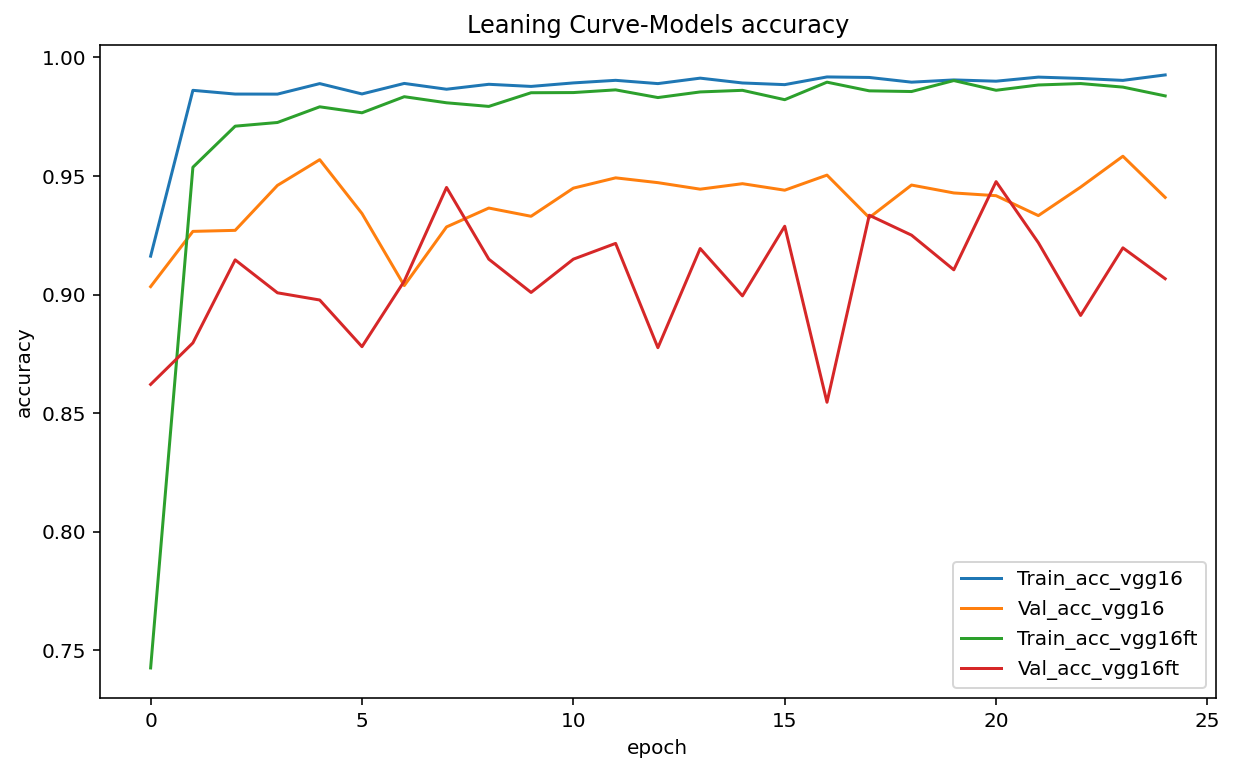

In [28]:
#Comparing results with no fine-tuning model

learning_vgg16=pd.read_csv(r'D:\fruits-360\trained_weights'+'\history_vgg16.csv', header=0, index_col=0)
learning_vgg16ft=pd.read_csv(r'D:\fruits-360\trained_weights'+'\history_vgg16_fine_tuning.csv', header=0, index_col=0)

plt.figure(figsize=(10,6))
plt.plot(learning_vgg16['accuracy'], label='Train_acc_vgg16')
plt.plot(learning_vgg16['val_accuracy'], label='Val_acc_vgg16')
plt.plot(learning_vgg16ft['accuracy'], label='Train_acc_vgg16ft')
plt.plot(learning_vgg16ft['val_accuracy'], label='Val_acc_vgg16ft')
plt.title('Leaning Curve-Models accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right');

In [11]:
#Accuracy value comparison with and without fine tuning

from tensorflow.keras.models import load_model
load_path=r'D:\fruits-360\trained_weights\fruits_25epoch_vgg16_fine_tuning.h5'
mod_vgg16.load_weights(load_path)
    
scores_train=mod_vgg16.evaluate(train_generator, verbose=1)
scores_validation=mod_vgg16.evaluate(val_generator, verbose=1)

  ...
    to  
  ['...']
1292/1292 [==============================] - 113s 88ms/step - loss: 0.0389 - accuracy: 0.9852
  ...
    to  
  ['...']
217/217 [==============================] - 19s 89ms/step - loss: 0.5227 - accuracy: 0.9068


Conclusions: As we seen in the results above, with the fine tuning model, we have even more overfitting, as we are calculating coefficients for previous layers and we are fitting more to the train subset, so the train error and val error values diverge even more. We will use the VGG16 model only with the fully connected layers available to train, 
and perform a hypermarameter optimization in next kernel.